In [1]:
from interarray.importer import load_repository
from interarray.plotting import gplot
from interarray.mesh import make_planar_embedding
from interarray.interarraylib import G_from_S
from interarray.heuristics import EW_presolver
from interarray.MILP import ortools as ort
from interarray.pathfinding import PathFinder

In [2]:
import logging
logging.getLogger('interarray').setLevel(logging.INFO)

## Initialize MILP solver

In [3]:
orter = ort.CpSat()

## Load interarray's locations

In [4]:
locations = load_repository()

## Optimize Moray East

In [8]:
L = locations.moray
capacity = 7

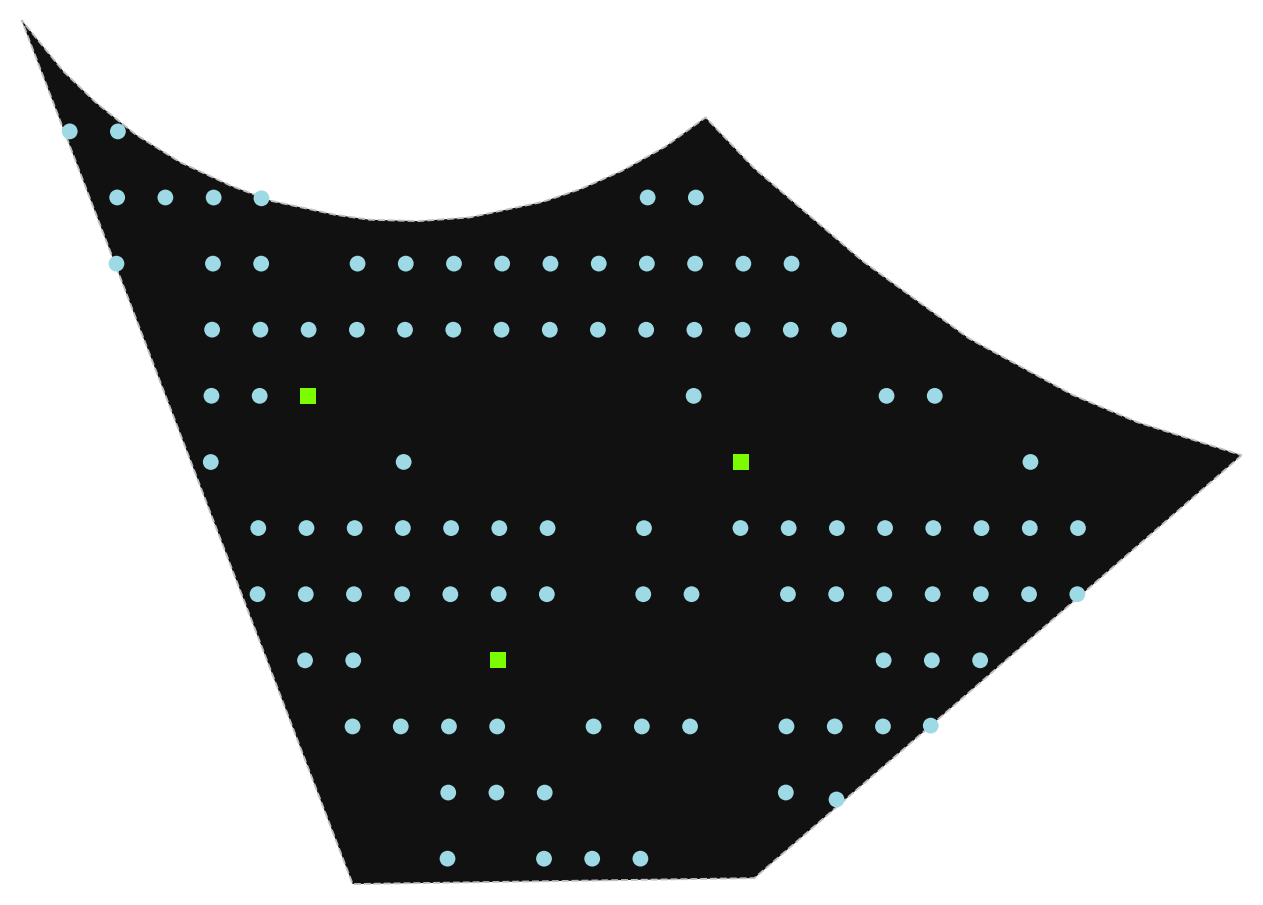

In [9]:
gplot(L);

In [10]:
P, A = make_planar_embedding(L)

Initial heuristic solution to warm-start the solver:

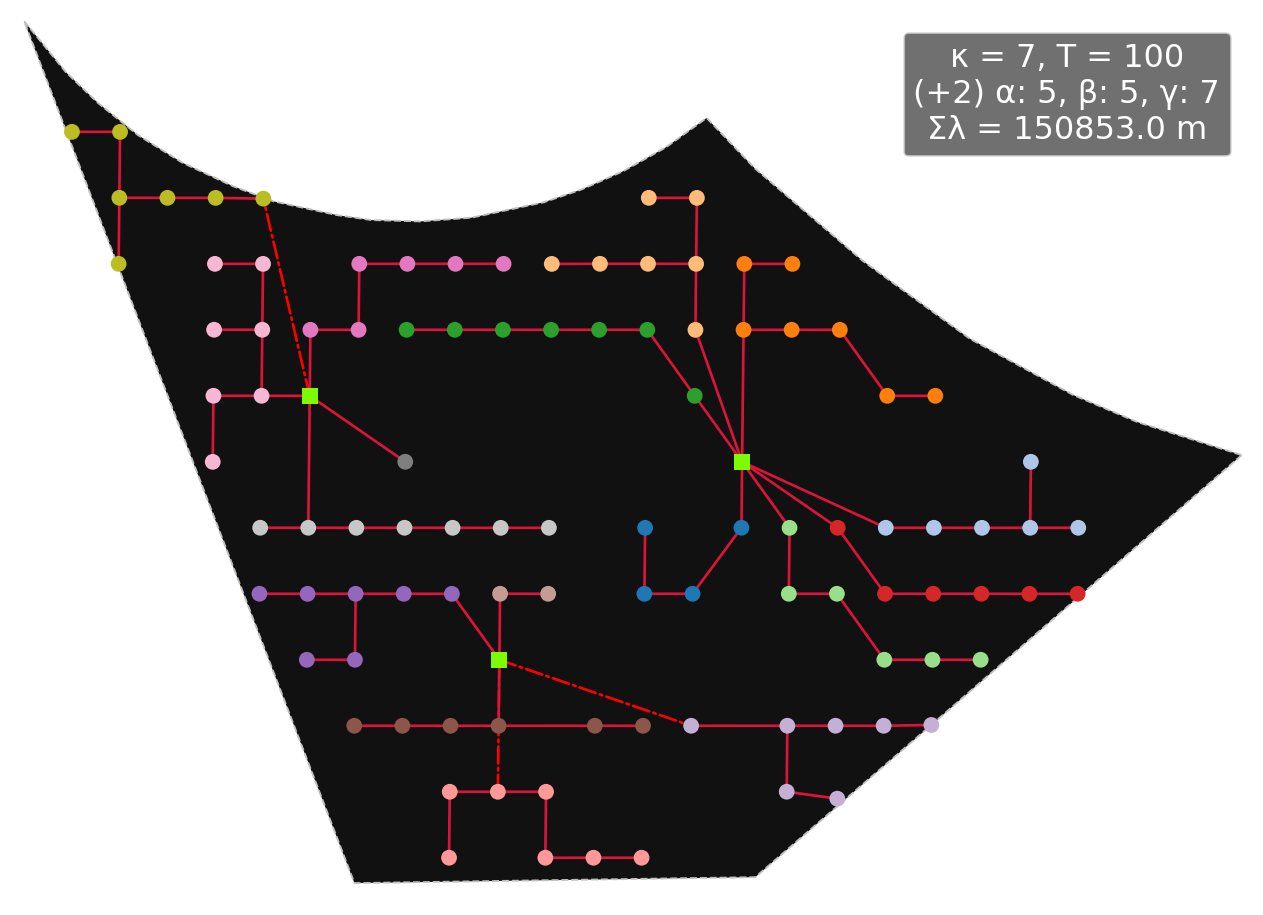

In [11]:
Sʹ = EW_presolver(A, capacity=capacity)
Gʹ = G_from_S(Sʹ, A)
gplot(Gʹ);

In [12]:
model = ort.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
ort.warmup_model(model, Sʹ);

In [12]:
orter.parameters.max_time_in_seconds = 40
orter.parameters.relative_gap_limit = 0.005
orter.parameters.num_workers = 8

# be verbose
orter.parameters.log_search_progress = True
# required to get the log inside the notebook (goes only to console otherwise)
orter.log_callback = print

result = orter.solve(model)

gap = 1 - orter.BestObjectiveBound()/orter.ObjectiveValue()
print('=================================================================',
      #orter.ResponseStats(),  # uncomment if orter.parameters.log_search_progress == False
      f"\nbest solution's strategy: {orter.SolutionInfo()}",
      f'\ngap: {100*gap:.1f}%')


Starting CP-SAT solver v9.11.4210
Parameters: max_time_in_seconds: 40 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model 'Moray East': (model_fingerprint: 0x7b9ac3fa114f13b7)
#Variables: 2'428 (#bools: 757 in floating point objective)
  - 1'671 Booleans in [0,1]
  - 457 in [-6,6]
  - 300 in [0,7]
#kAtMostOne: 423 (#literals: 1'922)
#kLinear1: 3'342 (#enforced: 3'342)
#kLinearN: 103 (#terms: 2'571)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 757 terms with magnitude in [1119.02, 18596.1] average = 4819.24
[Scaling] Objective coefficient relative error: 4.16209e-10
[Scaling] Objective worst-case absolute error: 9.52168e-05
[Scaling] Objective scaling factor: 1.04858e+06
  6.29e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.14e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  8.52e-05s  0.00e+00d  [op

Solution pool has 12 solutions.
Incumbent has (detoured) length: 143300.106
Pool investigation over - next best undetoured length: 143303.812


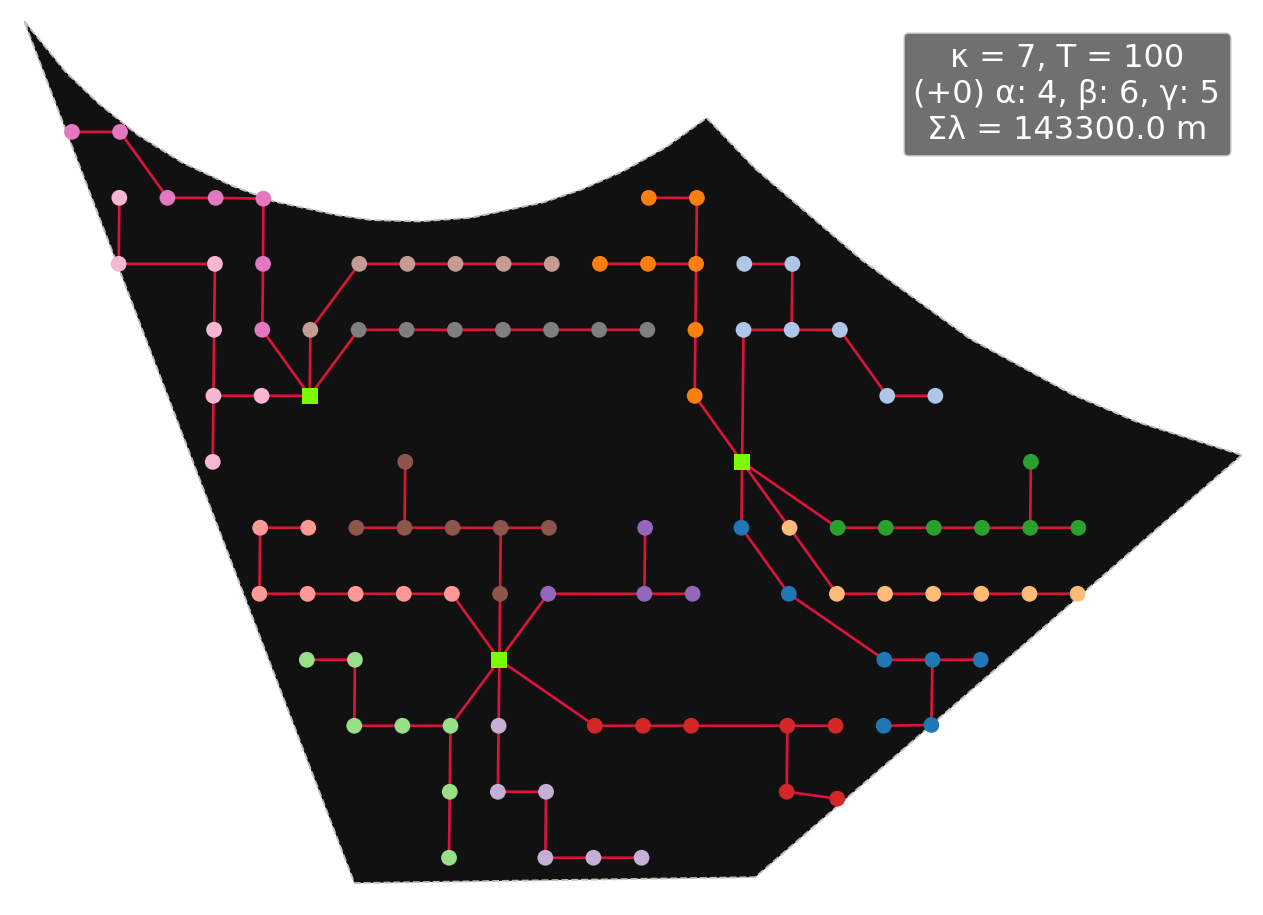

In [15]:
H = ort.investigate_pool(P, A, model, orter, result)
gplot(H);